In [1]:
%matplotlib inline
from fastai.basics import *

In this part of the lecture we explain Stochastic Gradient Descent (SGD) which is an **optimization** method commonly used in neural networks. We will illustrate the concepts with concrete examples.

#  Linear Regression problem

The goal of linear regression is to fit a line to a set of points.

In [2]:
n=100

Create a column of numbers for our x1's, and the x2's will all be 1

Since we pass in a total of 2 things, we get a rank 2 tensor of `n` by 2. The number of rows will be `n` and the number of columns will be 2. `torch.ones` means the tensor will be full of ones.

You can index into that just like you can index into a list in Python. But you can put a colon anywhere and a colon means every single value on that axis/dimension. This here `x[:,0]` means every single row of column 0. <br> 
So `x[:,0].uniform_(-1.,1)` is every row of column 0, I want you to grab uniform random numbers. 

Here is another very important concept in PyTorch. Anytime you've got a function that ends with an underscore, it means don't return to me that uniform random number, but replace whatever this is being called on with the result of this function. <br> 
So this `x[:,0].uniform_(-1.,1)` takes column 0 and replaces it with a uniform random number between -1 and 1.

In [3]:
x = torch.ones(n,2) 
x[:,0].uniform_(-1.,1)
x[:5]

tensor([[-0.0012,  1.0000],
        [-0.2200,  1.0000],
        [ 0.2928,  1.0000],
        [ 0.3478,  1.0000],
        [-0.2338,  1.0000]])

---
"Tensor" means array, but specifically it's an array of a regular shape. So it's not an array where row 1 has two things, row 3 has three things, and row 4 has one thing, what you call a "jagged array". That's not a tensor.  A tensor is any array which has a rectangular or cube or whatever ﹣ a shape where every row is the same length and every column is the same length. The following are all tensors:

- 4 by 3 matrix
- A vector of length 4
- A 3D array of length 3 by 4 by 6

They are expressed: (rows by columns)

We don't say dimensions, we either say rank or axis. Rank specifically means how many axes are there, how many dimensions are there. 

So an image is generally a rank 3 tensor. <br>
If you've got 64 images, then that would be a rank 4 tensor of 64 by 480 by 640 by 3.

---

Create some coefficients: <br>
a1 will be 3 (slope)<br>
a2 will be 2 (intercept)

This is a rank 1 tensor (also known as a vector).

In [4]:
a = tensor(3.,2); a

tensor([3., 2.])

`x@a` in Python means a matrix product between `x` and `a`.  And it actually is even more general than that. It can be a vector vector product, a matrix vector product, a vector matrix product, or a matrix matrix product. 

Then actually in PyTorch, specifically, it can mean even more general things where we get into higher rank tensors which we will learn all about very soon. But this is basically the key thing that's going to go on in all of our deep learning. The vast majority of the time, our computers are going to be basically doing this﹣multiplying numbers together and adding them up

In [5]:
y = x@a + torch.rand(n)

# torch.rand() adds in some noise

This covers most of what you need to know about PyTorch:

1. How to create an array
2. How to change things in an array
3. How to do matrix operations on an array

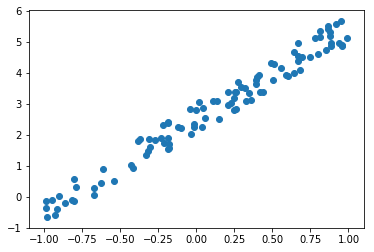

In [6]:
plt.scatter(x[:,0], y);

Now we are going to pretend we were given this data and we don't know that the values of our coefficients are (3 and 2).

How would we figure them out? How would we draw a line to fit this data and why would that even be interesting? The basic idea is:

>If we can find a way to find those two parameters to fit that line to those 100 points, we can also fit these arbitrary functions that convert from pixel values to probabilities.

It will turn out that these techniques that we're going to learn to find these two numbers works equally well for the 50 million numbers in ResNet34. So we're actually going to use an almost identical approach. This is the part people have the most trouble digesting.

>Student: I don't get it. How do we actually train these models?
>Jeremy: It's SGD. It's that thing we saw in the notebook with the 2 numbers.
>Student: yeah, but... but we are fitting a neural network. 
>Jeremy: I know and we can't print the 50 million numbers anymore, but it's literally identically doing the same thing.

The reason this is hard to digest is that the human brain has a lot of trouble conceptualizing of what an equation with 50 million numbers looks like and can do. So for now, you'll have to take my word for it. It can do things like recognize teddy bears. All these functions turn out to be very powerful. We're going to learn about how to make them extra powerful. But for now, this thing we're going to learn to fit these two numbers is the same thing that we've just been using to fit 50 million numbers. 

---
We want to find **parameters** (weights) `a` such that you minimize the *error* between the points and the line `x@a`. Note that here `a` is unknown. For a regression problem the most common *error function* or *loss function* is the **mean squared error**. 

For this kind of problem which is called a regression problem (a problem where your dependent variable is continuous, so rather than being grizzlies or teddies, it's some number between -1 and 6), the most common loss function is called mean squared error which pretty much everybody calls MSE. You may also see RMSE which is root mean squared error. The mean squared error is a loss which is the difference between some predictions that you made which is like the value of the line and the actual number of ice cream sales. In the mathematics of this, people normally refer to the actual as y and the prediction, they normally call it y hat.

So the value of mean squared error is simply the difference between those two (y_hat - y) squared. Then we can take the mean because both y_hat and y are rank 1 tensors, so we subtract one vector from another vector, it does something called "element-wise arithmetic" in other words, it subtracts each one from each other, so we end up with a vector of differences. Then if we take the square of that, it squares everything in that vector. So then we can take the mean of that to find the average square of the differences between the actuals and the predictions.

In [7]:
def mse(y_hat, y): return ((y_hat-y)**2).mean()

Suppose we believe `a = (-1.0,1.0)` then we can compute `y_hat` which is our *prediction* and then compute our error. 

In [8]:
a = tensor(-1.,1)

# include the . to make it a float tensor

So now we can calculate our predictions with this random guess. `x@a` a matrix product of `x` and `a`. And we can now calculate the mean squared error of our predictions and their actuals, and that's our loss. So for this regression, our loss is 0.9.

In [9]:
y_hat = x@a
mse(y_hat, y)

tensor(8.9959)

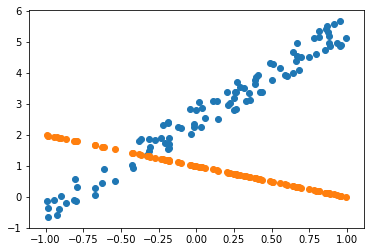

In [10]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_hat);

So that is not great﹣not surprising. It's just a guess. 

SGD is basically about taking this guess and trying to make it a little bit better. How do we make it a little better? Well, there are only two numbers and the two numbers are:

the intercept of the orange line and the gradient of the orange line. 

So what we are going to do with gradient descent is we're going to simply say:

What if we changed those two numbers a little bit?:

     What if we made the intercept a little bit higher or a little bit lower?
     What if we made the gradient a little bit more positive or a little bit more negative?

There are 4 possibilities and then we can calculate the loss for each of those 4 possibilities and see what works. Did lifting it up or down make it better? Did tilting it more positive or more negative make it better? And then all we do is we say, okay, whichever one of those made it better, that's what we're going to do. That's it.

But here is the cool thing for those of you that remember calculus. You don't actually have to move it up and down, and round about. You can actually calculate the derivative. 

The derivative is the thing that tells you would moving it up or down make it better, or would rotating it this way or that way make it better. The good news is if you didn't do calculus or you don't remember calculus, I just told you everything you need to know about it. It tells you how changing one thing changes the function. That's what the derivative is, kind of, not quite strictly speaking, but close enough, also called the gradient. The gradient or the derivative tells you how changing [a_1] up or down would change our MSE, how changing [a_2] up or down would change our MSE, and this does it more quickly than actually moving it up and down.

# Gradient Descent

We would like to find the values of `a` that minimize `mse_loss`.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.


So here is what we're going to do. We are going to create a loop. We're going to loop through 100 times, and we're going to call a function called `update`. That function is going to:

- Calculate `y_hat` (i.e. our prediction)

- Calculate loss (i.e. our mean squared error)

- From time to time, it will print that out so we can see how we're going

- Calculate the gradient. In PyTorch, calculating the gradient is done by using a method called `backward`. Mean squared error was just a simple standard mathematical function. PyTorch keeps track of how it was calculated and lets us calculate the derivative. So if you do a mathematical operation on a tensor in PyTorch, you can call `backward` to calculate the derivative and the derivative gets stuck inside an attribute called `.grad`. 

- Take my coefficients and I'm going to subtract from them my gradient (`sub_`). There is an underscore there because that's going to do it in-place. It's going to actually update those coefficients `a` to subtract the gradients from them. Why do we subtract? Because the gradient tells us if I move the whole thing downwards, the loss goes up. If I move the whole thing upwards, the loss goes down. So I want to do the opposite of the thing that makes it go up. We want our loss to be small. That's why we subtract.

- `lr` is our learning rate. All it is is the thing that we multiply by the gradient. In other words, we find our gradient to tell us what direction to go and if we have to go a long way or not too far. But then we multiply it by some number less than 1 so we don't jump too far.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [11]:
a = nn.Parameter(a); a

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [12]:
def update():
    y_hat = x@a
    loss = mse(y, y_hat)
    if t % 10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_()

In [13]:
lr = 1e-1
for t in range(100): update()

tensor(8.9959, grad_fn=<MeanBackward1>)
tensor(1.2730, grad_fn=<MeanBackward1>)
tensor(0.3900, grad_fn=<MeanBackward1>)
tensor(0.1677, grad_fn=<MeanBackward1>)
tensor(0.1088, grad_fn=<MeanBackward1>)
tensor(0.0932, grad_fn=<MeanBackward1>)
tensor(0.0890, grad_fn=<MeanBackward1>)
tensor(0.0879, grad_fn=<MeanBackward1>)
tensor(0.0876, grad_fn=<MeanBackward1>)
tensor(0.0875, grad_fn=<MeanBackward1>)


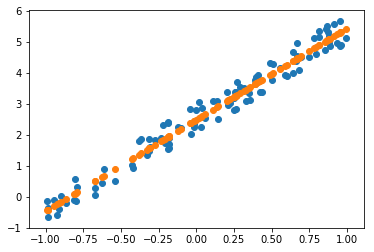

In [14]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],x@a);

## Animate it!

In [15]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [16]:
a = nn.Parameter(tensor(-1.,1))

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot(x[:,0], x@a)
plt.close()

def animate(i):
    update()
    line.set_ydata(x@a)
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)

In practice, we don't calculate on the whole file at once, but we use *mini-batches*.

## Vocab

- **Learning rate**: A thing we multiply our gradient by to decide how much to update the weights by.

- **Epoch**: One complete run through all of our data points (e.g. all of our images). So for non-stochastic gradient descent we just did, every single loop, we did the entire dataset. But if you've got a dataset with a thousand images and our mini-batch size is 100, then it would take you 10 iterations to see every image once. So that would be one epoch. Epochs are important because if you do lots of epochs, then you are looking at your images lots of times, so every time you see an image, there's a bigger chance of overfitting. So we generally don't want to do too many epochs.

- **Mini-batch**: A random bunch of points that you use to update your weights.

- **SGD**: Gradient descent using mini-batches.

- **Model / Architecture**: They kind of mean the same thing. In this case, our architecture is <img src="http://latex.codecogs.com/gif.latex?\vec{y}&space;=&space;X\vec{a}" title="\vec{y} = X\vec{a}" />﹣ the architecture is the mathematical function that you're fitting the parameters to. And we're going to learn later today or next week what the mathematical function of things like ResNet34 actually is. But it's basically pretty much what you've just seen. It's a bunch of matrix products. 

- **Parameters / Coefficients / Weights**: Numbers that you are updating.

- **Loss function**: The thing that's telling you how far away or how close you are to the correct answer. For classification problems, we use *cross entropy loss*, also known as *negative log likelihood loss*. This penalizes incorrect confident predictions, and correct unconfident predictions.

For classification problems, we use *cross entropy loss*, also known as *negative log likelihood loss*. This penalizes incorrect confident predictions, and correct unconfident predictions.